## Importing Libaraies¶


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, accuracy_score


In [2]:
# Set random seed for reproducibility
import tensorflow as tf
tf.random.set_seed(3)
np.random.seed(3)

# Base directory
base_dir = "/kaggle/input/leapgestrecog/leapGestRecog"

##  Step 1: Load Data

In [3]:
data = []
for sub_dir in os.listdir(base_dir):
    sub_dir_path = os.path.join(base_dir, sub_dir)
    if os.path.isdir(sub_dir_path):
        for label in os.listdir(sub_dir_path):
            label_path = os.path.join(sub_dir_path, label)
            if os.path.isdir(label_path):
                for image_file in os.listdir(label_path):
                    if image_file.endswith(('.png', '.jpg', '.jpeg')):
                        image_path = os.path.join(label_path, image_file)
                        data.append({'image_path': image_path, 'label': label})

# Convert data into a DataFrame
df = pd.DataFrame(data)

## Step 2: Split Dataset


In [4]:
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)


In [5]:
# Encode labels
label_encoder = LabelEncoder()
one_hot_encoder = OneHotEncoder(sparse=False)

Y_train_int = label_encoder.fit_transform(train_df['label'])
Y_train = one_hot_encoder.fit_transform(Y_train_int.reshape(-1, 1))

Y_val_int = label_encoder.transform(val_df['label'])
Y_val = one_hot_encoder.transform(Y_val_int.reshape(-1, 1))

Y_test_int = label_encoder.transform(test_df['label'])
Y_test = one_hot_encoder.transform(Y_test_int.reshape(-1, 1))

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


## Step 3: Image Processing

In [6]:
def process_images(file_paths, target_size=(224, 224)):
    images = []
    for path in file_paths:
        img = load_img(path, target_size=target_size)
        img_array = img_to_array(img) / 255.0
        images.append(img_array)
    return np.array(images)

X_train = process_images(train_df['image_path'])
X_val = process_images(val_df['image_path'])
X_test = process_images(test_df['image_path'])

In [7]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train)


## Step 4: Load Pre-trained Xception Model

In [8]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  # Add dropout for regularization
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)  # Add another dropout layer
predictions = Dense(len(label_encoder.classes_), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze base model layers for transfer learning
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


## Step 5: Train the Model

In [9]:
history = model.fit(
    datagen.flow(X_train, Y_train, batch_size=32),
    validation_data=(X_val, Y_val),
    epochs=15
)


Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1734445259.578818      67 service.cc:145] XLA service 0x7f87f8004e00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734445259.578887      67 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734445259.578892      67 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  1/438 ━━━━━━━━━━━━━━━━━━━━ 2:20:45 19s/step - accuracy: 0.1250 - loss: 2.3671

I0000 00:00:1734445272.312767      67 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


438/438 ━━━━━━━━━━━━━━━━━━━━ 180s 367ms/step - accuracy: 0.2851 - loss: 2.0044 - val_accuracy: 0.8807 - val_loss: 0.6429
Epoch 2/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 141s 316ms/step - accuracy: 0.6734 - loss: 1.0122 - val_accuracy: 0.9487 - val_loss: 0.3177
Epoch 3/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 140s 314ms/step - accuracy: 0.7544 - loss: 0.7471 - val_accuracy: 0.9657 - val_loss: 0.1996
Epoch 4/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 140s 315ms/step - accuracy: 0.8093 - loss: 0.5953 - val_accuracy: 0.9733 - val_loss: 0.1525
Epoch 5/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 141s 318ms/step - accuracy: 0.8278 - loss: 0.5353 - val_accuracy: 0.9843 - val_loss: 0.1158
Epoch 6/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 139s 313ms/step - accuracy: 0.8479 - loss: 0.4639 - val_accuracy: 0.9860 - val_loss: 0.0963
Epoch 7/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 140s 314ms/step - accuracy: 0.8593 - loss: 0.4266 - val_accuracy: 0.9893 - val_loss: 0.0800
Epoch 8/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 140s 314ms/step - accuracy: 0.8720 - loss: 0.38

##  Step 6: Evaluate the Model

Test Accuracy: 99.27%
94/94 ━━━━━━━━━━━━━━━━━━━━ 15s 141ms/step


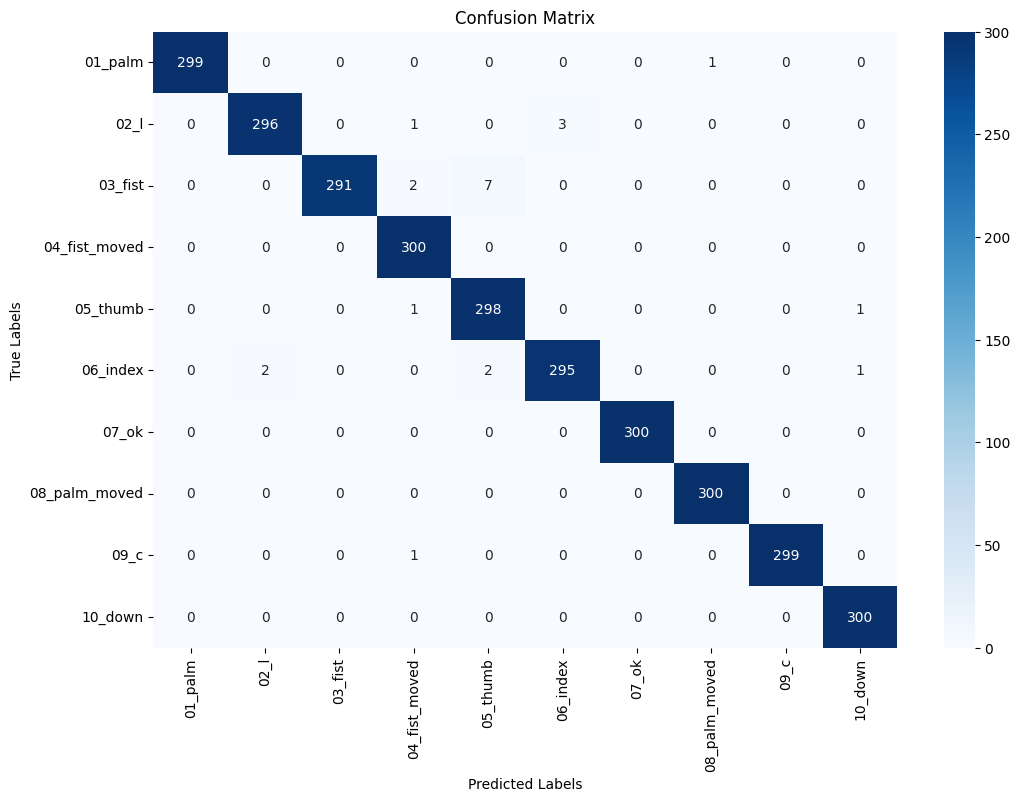

               precision    recall  f1-score   support

      01_palm       1.00      1.00      1.00       300
         02_l       0.99      0.99      0.99       300
      03_fist       1.00      0.97      0.98       300
04_fist_moved       0.98      1.00      0.99       300
     05_thumb       0.97      0.99      0.98       300
     06_index       0.99      0.98      0.99       300
        07_ok       1.00      1.00      1.00       300
08_palm_moved       1.00      1.00      1.00       300
         09_c       1.00      1.00      1.00       300
      10_down       0.99      1.00      1.00       300

     accuracy                           0.99      3000
    macro avg       0.99      0.99      0.99      3000
 weighted avg       0.99      0.99      0.99      3000

ROC-AUC Score: 1.00


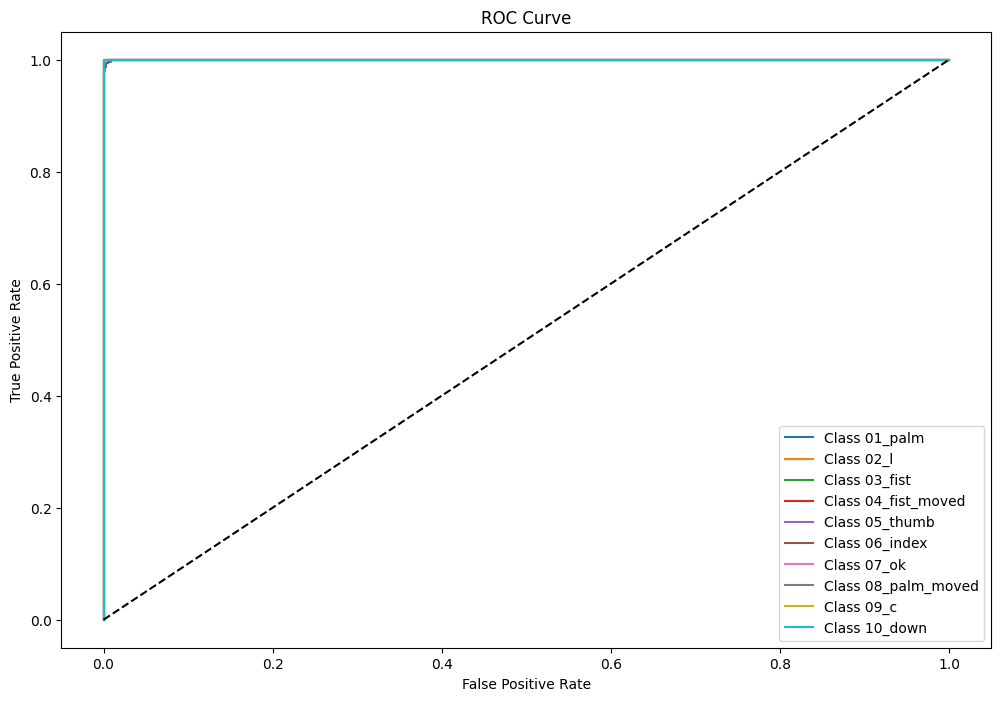

In [10]:
loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Generate predictions
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true_classes = np.argmax(Y_test, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(Y_true_classes, Y_pred_classes)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(Y_true_classes, Y_pred_classes, target_names=label_encoder.classes_))

# ROC-AUC Curve
roc_auc = roc_auc_score(Y_test, Y_pred, multi_class='ovr')
print(f"ROC-AUC Score: {roc_auc:.2f}")

# Plot ROC Curve
fpr = {}
tpr = {}
thresholds = {}
for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], thresholds[i] = roc_curve(Y_test[:, i], Y_pred[:, i])

plt.figure(figsize=(12, 8))
for i in range(len(label_encoder.classes_)):
    plt.plot(fpr[i], tpr[i], label=f"Class {label_encoder.classes_[i]}")
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()